The dataset which we will get the national interest expense from is the U.S. Treasury's "Monthly Treasury Statement." The statement is produced at the end of each month and includes a detailed outline of every receipt and outlay for the U.S. government, including gross interest on Treasury Securities. The data used here were accessed on March 28, 2023. As such, the dataset spans March 31, 2015 to February 28, 2023.

Since there's a lot of extraneous information in the dataset, I'm going to take the interest related expenses and save them to their own file in case I need it later.

In [14]:
mts = pd.read_csv("/Users/avery/JupyterProjects/Treasury/Data/MTSOutlay.csv")
mts["Record Date"] = pd.to_datetime(mts["Record Date"])

interestOnly = mts[(mts['Classification Description'] == 'Public Issues (Accrual Basis)') | 
                   (mts['Classification Description'] == 'Special Issues (Cash Basis)') | 
                   (mts['Classification Description'] == 'Total--Interest on Treasury Debt Securities (Gross)')]

interestOnly.to_csv('/Users/avery/JupyterProjects/Treasury/Data/Out/InterestOnly.csv', index=False)
del mts

To take a look at this data, I'll go ahead and make a plot of the total interest paid on Treasury Securities for each month going back to the start of the dataset.

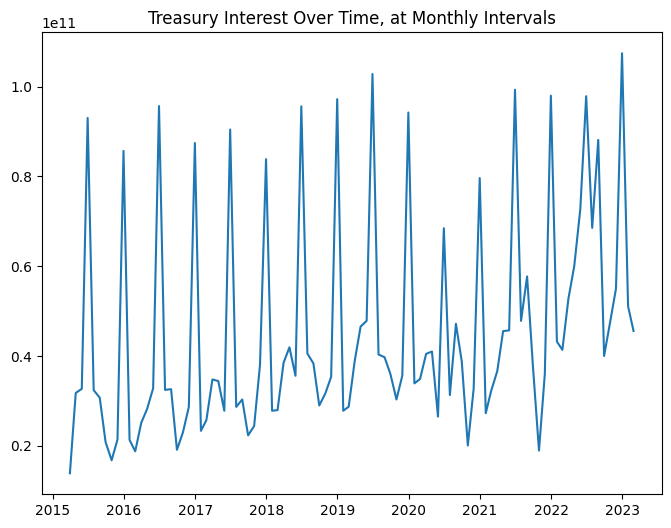

In [49]:
from matplotlib import pyplot as plt

date = interestOnly[interestOnly['Classification Description'] == 'Total--Interest on Treasury Debt Securities (Gross)']
date = date.loc[:,"Record Date"]
total = interestOnly[interestOnly['Classification Description'] == 'Total--Interest on Treasury Debt Securities (Gross)']
y = total.loc[:,"Current Month Gross Outlay Amount"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(date, y)
plt.title('Treasury Interest Over Time, at Monthly Intervals')
plt.show()

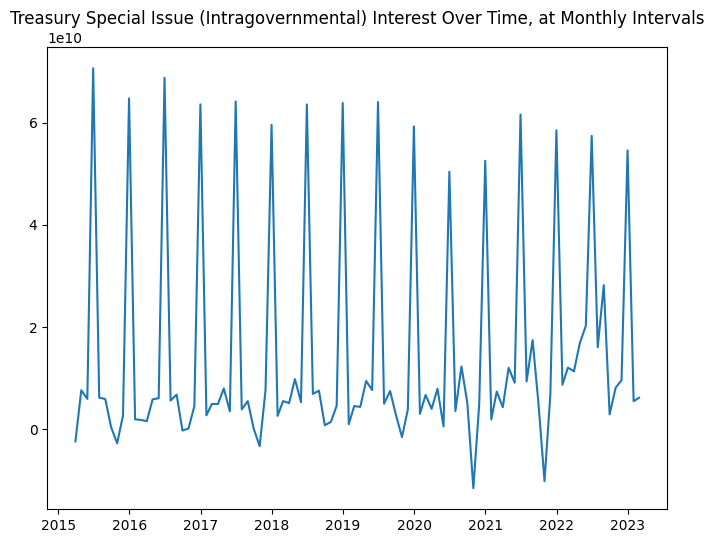

In [48]:
date = interestOnly[interestOnly['Classification Description'] == 'Special Issues (Cash Basis)']
date = date.loc[:,"Record Date"]
special = interestOnly[interestOnly['Classification Description'] == 'Special Issues (Cash Basis)']
y = special.loc[:,"Current Month Gross Outlay Amount"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(date, y)
plt.title('Treasury Special Issue (Intragovernmental) Interest Over Time, at Monthly Intervals')
plt.show()

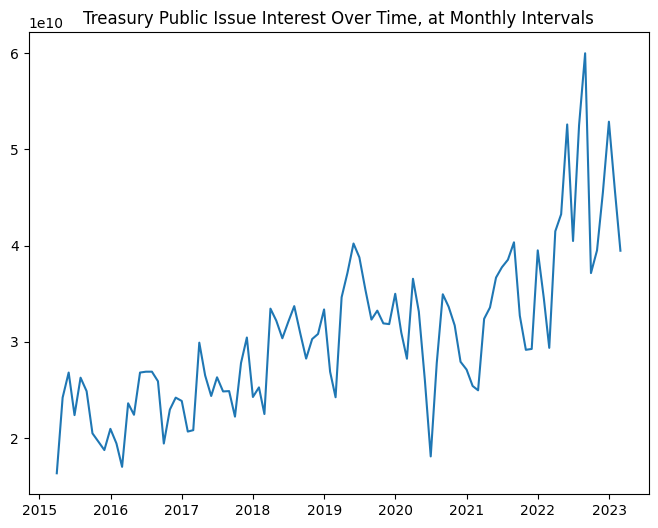

In [47]:
date = interestOnly[interestOnly['Classification Description'] == 'Public Issues (Accrual Basis)']
date = date.loc[:,"Record Date"]
public = interestOnly[interestOnly['Classification Description'] == 'Public Issues (Accrual Basis)']
y = public.loc[:,"Current Month Gross Outlay Amount"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(date, y)
plt.title('Treasury Public Issue Interest Over Time, at Monthly Intervals')
plt.show()

Each type has considerable seasonal variability, but it is evident that the annual spikes mostly come from the special issues, or intragovernmental debt. To better understand the trends here, I'm going to decompose each type of interest. Starting with the special issues:

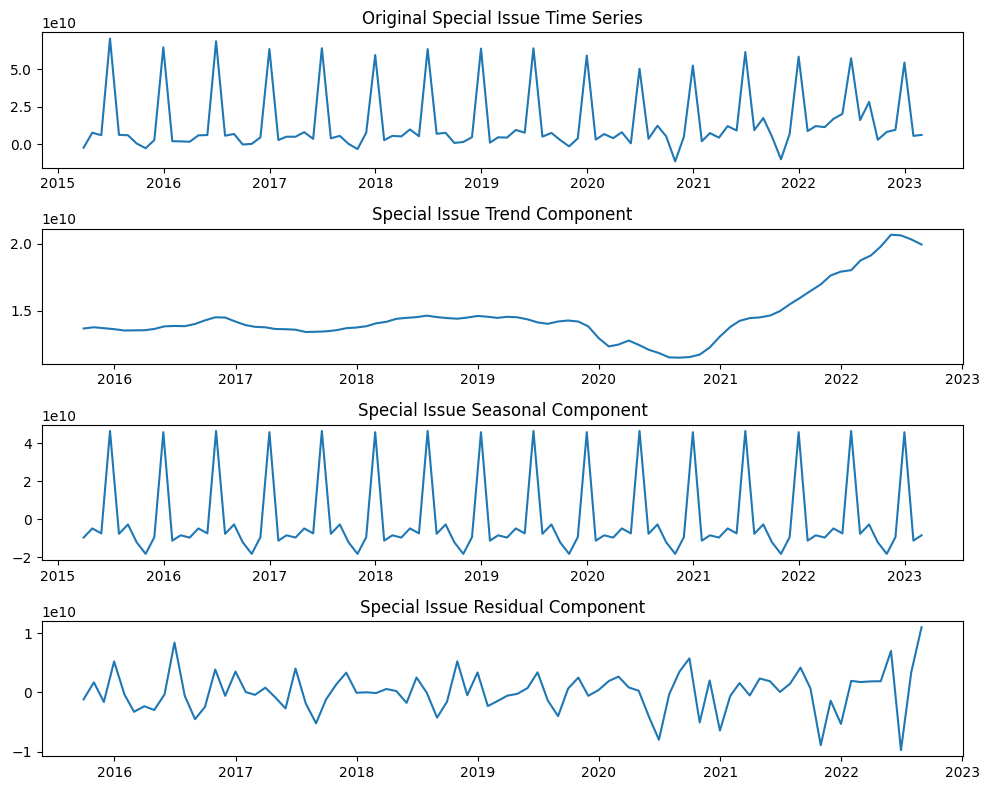

In [116]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(special['Current Month Gross Outlay Amount'], model='additive', period=12)

trendSpecial = decomposition.trend
seasonalSpecial = decomposition.seasonal
residualSpecial = decomposition.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(date, special['Current Month Gross Outlay Amount'])
plt.title('Original Special Issue Time Series')
plt.subplot(412)
plt.plot(date, trendSpecial)
plt.title('Special Issue Trend Component')
plt.subplot(413)
plt.plot(date, seasonalSpecial)
plt.title('Special Issue Seasonal Component')
plt.subplot(414)
plt.plot(date, residualSpecial)
plt.title('Special Issue Residual Component')
plt.tight_layout()
plt.show()

Now decomposing the Public portion of the interest:

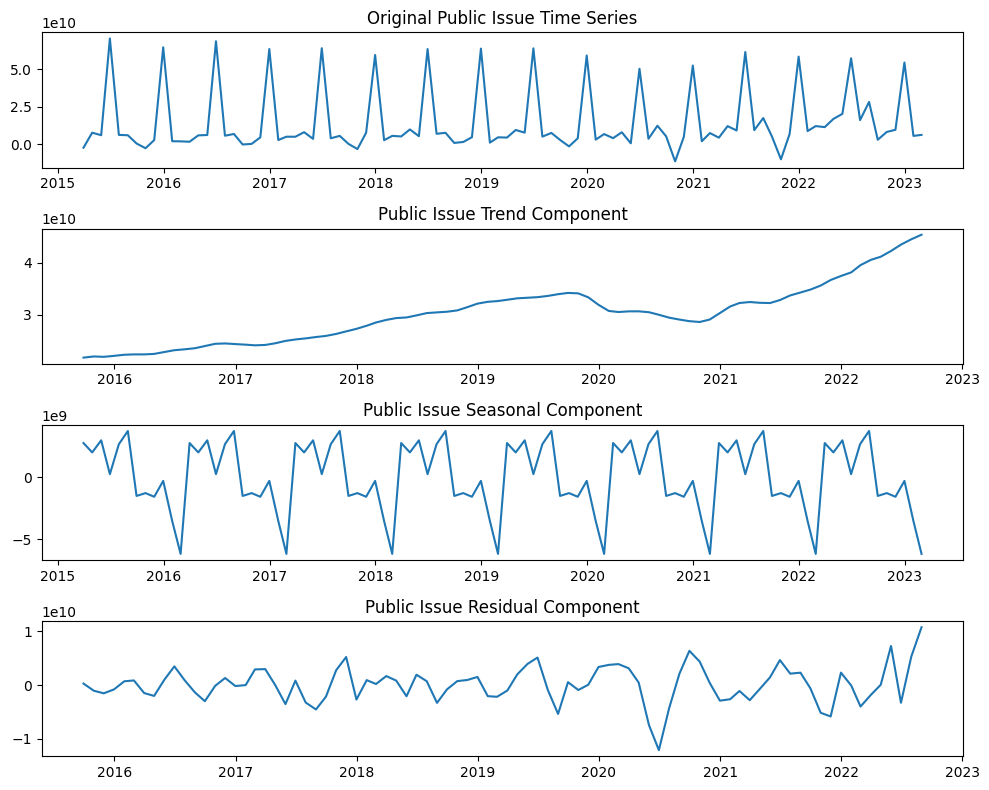

In [127]:
decomposition = seasonal_decompose(public['Current Month Gross Outlay Amount'], model='additive', period=12)

trendPublic = decomposition.trend
seasonalPublic = decomposition.seasonal
residualPublic = decomposition.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(date, special['Current Month Gross Outlay Amount'])
plt.title('Original Public Issue Time Series')
plt.subplot(412)
plt.plot(date, trendPublic)
plt.title('Public Issue Trend Component')
plt.subplot(413)
plt.plot(date, seasonalPublic)
plt.title('Public Issue Seasonal Component')
plt.subplot(414)
plt.plot(date, residualPublic)
plt.title('Public Issue Residual Component')
plt.tight_layout()
plt.show()

Might as well do the totals too:

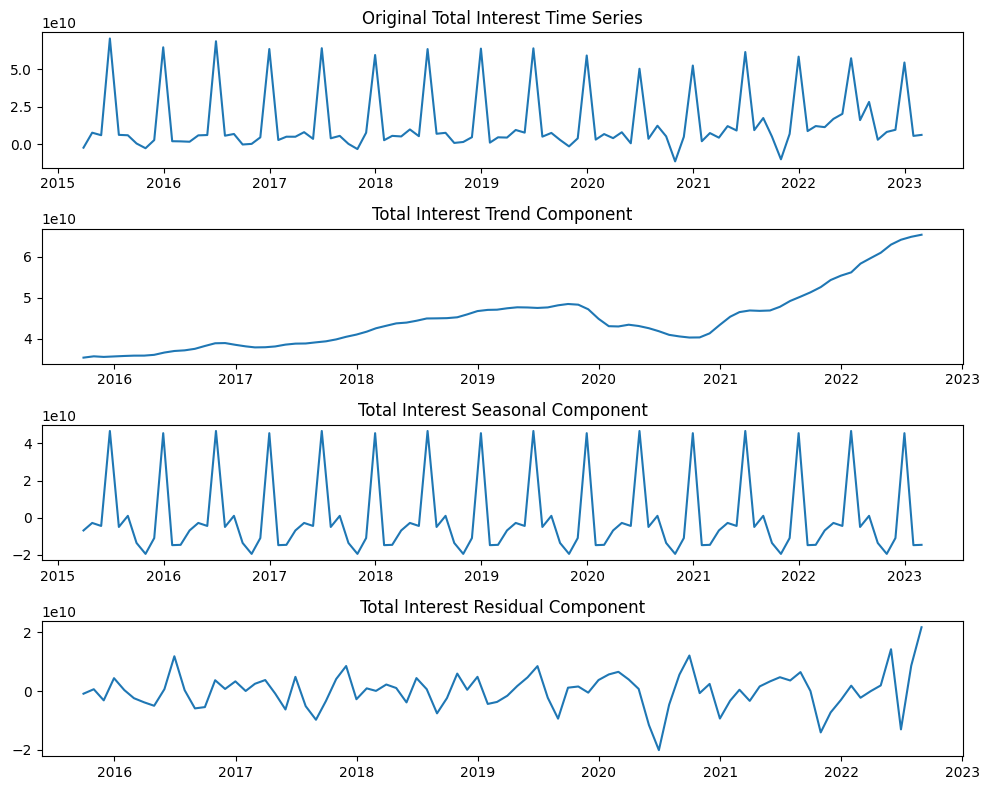

In [118]:
decomposition = seasonal_decompose(total['Current Month Gross Outlay Amount'], model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend.index = total.index
seasonal.index = total.index
residual.index = total.index

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(date, special['Current Month Gross Outlay Amount'])
plt.title('Original Total Interest Time Series')
plt.subplot(412)
plt.plot(date, trend)
plt.title('Total Interest Trend Component')
plt.subplot(413)
plt.plot(date, seasonal)
plt.title('Total Interest Seasonal Component')
plt.subplot(414)
plt.plot(date, residual)
plt.title('Total Interest Residual Component')
plt.tight_layout()
plt.show()

The seasonal component appears to be mostly removed now and the trend is as expected. A small peak in 2019 following the rate increases made by the FED back then, and a much larger occuring now due to the rate increases we're seeing in 2022-2023. I think its worth comparing the trend with FED Funds data. First, I'm going to make that trend series more useful though.

In [119]:
trend = trend.to_frame(name='Trend')

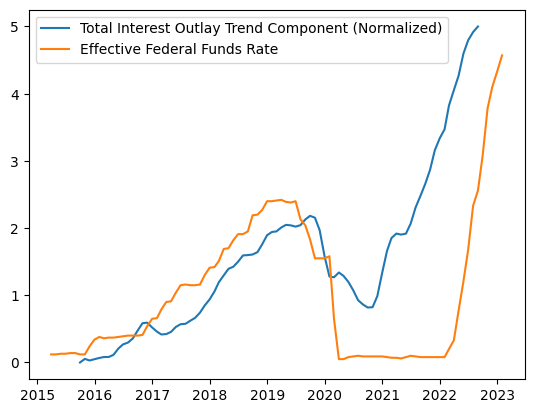

In [120]:
fedFunds = pd.read_csv("/Users/avery/JupyterProjects/Treasury/Data/FEDFUNDS.csv")
fedFunds["DATE"] = pd.to_datetime(fedFunds["DATE"])

import numpy as np

# Dropping the first row of the dataset since the FED Funds data is recorded at the beginning of the month, not the end.
# Therefore, shifting it back a month lines it up better. I'll add NaN as the final month's value.
fedFunds = fedFunds.drop(fedFunds.index[0])
new_row = pd.DataFrame({'DATE': pd.to_datetime('2023-03-01'), 'FEDFUNDS': np.nan}, index=[0])
fedFunds = pd.concat([fedFunds, new_row], axis=0, ignore_index=True)
fedFundsrev = fedFunds.iloc[::-1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 5))
trendNormal = scaler.fit_transform(trend['Trend'].values.reshape(-1, 1))

plt.plot(date, trendNormal, label='Total Interest Outlay Trend Component (Normalized)')
plt.plot(date, fedFundsrev['FEDFUNDS'], label='Effective Federal Funds Rate')
plt.legend()
plt.show()

Now I know my graphing skills aren't perfect, but the spike in the trend during the middle of 2021 does seem odd to me. Perhaps it's due to the sheer increase in debt balance that occured during the COVID period. Let's throw total debt into the mix.

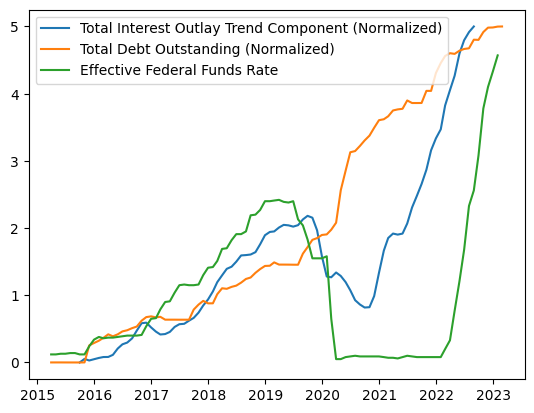

In [121]:
totalDebt = pd.read_csv("/Users/avery/JupyterProjects/Treasury/Data/DebtToPenny.csv", index_col="Record Date", parse_dates=True)

totalDebt = totalDebt.groupby(pd.Grouper(freq='M')).tail(1)
totalDebt = totalDebt.drop(totalDebt.index[-1])
totalDebt = totalDebt.loc['2015-03-31':'2023-02-28']
debtrev = totalDebt.iloc[::-1]

debtNormal = scaler.fit_transform(debtrev['Total Public Debt Outstanding'].values.reshape(-1, 1))

plt.plot(date, trendNormal, label='Total Interest Outlay Trend Component (Normalized)')
plt.plot(date, debtNormal, label='Total Debt Outstanding (Normalized)')
plt.plot(date, fedFundsrev['FEDFUNDS'], label='Effective Federal Funds Rate')
plt.legend()
plt.show()

Nothing is really confirmed here and I'm still not sure what's causing the increase in 2021. It may be the balance increase, it may not. Part of the problem here is the amount of lag between increases in interest or balance is not very consistent. I'll have to dig deeper to figure this one out. 

In [125]:
print(trend.tail(10))

              Trend
69046  3.570129e+10
69827  3.558578e+10
70632  3.572938e+10
71417  3.540961e+10
72246           NaN
73038           NaN
73996           NaN
74659           NaN
75290           NaN
76709           NaN
